# TO DO
- Update readme and other instructions
- Resolve Scaling issue - currently the scaling doesn't seem to work on granules 16, 20, 24, or 29. These HLS Granules don't have the scale factor in the proper location in the metadata and somewhere within xarray or rioxarray this data is used regardless of whether `mask_and_sale=True`. I tried to implement a manual scaling process if the granule has an average value higher than what would be expected for reflectance values, but this doesn't seem to work for an unknown reason.

# Getting Started with Cloud-Native HLS Data in Python

**Summary**

This tutorial was developed using an example use case for crop monitoring over a single large farm field in northern California. **The goal of the project is to observe HLS-derived mean EVI over a farm field in northern California without downloading the entirety of the HLS source data.** In this notebook we will extract and EVI timeseries from Harmonized Landsat Sentinel-2 (HLS) data in the Cloud using CMR's SpatioTemporal Asset Catalog (CMR-STAC).  This tutorial will show how to use the CMR-STAC API to investigate the HLS collections available in the cloud and search for and subset to the specific time period, bands (layers), and region of interest for our use case, load subsets of the desired COGs into a Jupyter Notebook directly from the cloud, quality filter and calculate EVI, stack the time series, visualize the time series, and export a CSV of statistics on the EVI of the single farm field.  

**Background**

The  Harmonized Landsat Sentinel-2 ([HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/)) project produces seamless, harmonized surface reflectance data from the Operational Land Imager (OLI) and Multi-Spectral Instrument (MSI) aboard Landsat and Sentinel-2 Earth-observing satellites, respectively. The aim is to produce seamless products with normalized parameters, which include atmospheric correction, cloud and cloud-shadow masking, geographic co-registration and common gridding, normalized bidirectional reflectance distribution function, and spectral band adjustment. This will provide global observation of the Earth’s surface every 2-3 days with 30 meter spatial resolution. One of the major applications that will benefit from HLS is agriculture assessment and monitoring, which is used as the use case for this tutorial.  

NASA's Land Processes Distributed Active Archive Center (LP DAAC) archives and distributes HLS products in the LP DAAC Cumulus cloud archive as Cloud Optimized GeoTIFFs (COG). This tutorial will demonstrate  Because these data are stored as COGs, this tutorial will teach users how to load subsets of individual files into memory for just the bands you are interested in--a paradigm shift from the more common workflow where you would need to download a .zip/HDF file containing every band over the entire scene/tile. This tutorial covers how to process HLS data (quality filtering and EVI calculation), visualize, and "stack" the scenes over a region of interest into an [xarray](http://xarray.pydata.org/en/stable/) data array, calculate statistics for an EVI time series, and export as a comma-separated values (CSV) file--providing you with all of the information you need for your area of interest without having to download the source data file. The Enhanced Vegetation Index ([EVI](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_4.php)), is a vegetation index similar to NDVI that has been found to be more sensitive to ground cover below the vegetated canopy and saturates less over areas of dense green vegetation.  

**Requirements**

- A [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download the data used in this tutorial. You can create an account at the link provided.
- You will will also need to have a netrc file set up in your home directory in order to successfully run the code below. A code chunk in a later section provides a way to do this, or you can check out the [setup_intstructions.md](../../python/setup/setup_instructions.md).

**Learning Objectives**

- How to work with HLS Landsat ([HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)) and Sentinel-2 ([HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)) data products
- How to query and subset HLS data using the NASA Common Metadata Repository (CMR) SpatioTemporal Asset Catalog (STAC) application programming interface (API)
- How to access and work with cloud stored HLS data 
- How to filter data using HLS quality information

**Tutorial Outline**

1. [**Getting Started**](#getstarted)  
    1.1 Import Packages and Set up the Working Environment         
2. [**Navigating the CMR-STAC API**](#navigatestac)      
    2.1 Introduction to the CMR-STAC API     
3. [**CMR-STAC API: Searching for Items**](#searchstac)      
    3.1 Spatial Querying via Bounding Box  
    3.2 Temporal Querying  
4. [**Extracting HLS COGs from the Cloud**](#extracthls)        
    4.1 Subset by Band   
    4.2 Load a Spatially Subset HLS COG into Memory  
5. [**Processing HLS Data**](#processhls)    
    5.1 Apply Scale Factor and Calculate EVI    
    5.2 Quality Filtering   
    5.3 Export to COG   
6. [**Automation**](#automation)     
7. [**Stacking HLS Data**](#stackhls)    
    7.1 Open COGs and Stack Using Xarray      
    7.2 Visualize Stacked Time Series  
    7.3 Export Statistics 

**Data Used in the Example**  

- Daily 30 meter (m) global HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance - [HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)
    - The HLSS30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Sentinel-2A and Sentinel-2B MSI data products._  
     - Science Dataset (SDS) layers: 
        - B8A (NIR Narrow)  
        - B04 (Red)  
        - B02 (Blue)  
        - Fmask (Quality)    

- Daily 30 meter (m) global HLS Landsat-8 OLI Surface Reflectance - [HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)
    - The HLSL30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat-8 OLI data products.  
     - Science Dataset (SDS) layers:
        - B05 (NIR)  
        - B04 (Red)  
        - B02 (Blue)  
        - Fmask (Quality)  

---

## 1. Getting Started <a id="getstarted"></a>

### 1.1 Import Packages <a id="1.1"></a>

Import the required packages.

In [ ]:
import os
from datetime import datetime
import requests as r
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio as rio
import xarray as xr
import rioxarray as rxr
from cartopy import crs
import hvplot.xarray
import hvplot.pandas
import json
import panel as pn
import earthaccess

### 1.2 EarthData Login

Use earthaccess to sign into your earthdata login. This function uses a local `.netrc` file to store credentials. If you do not have a `.netrc` file, you will be prompted for your credentials and one will be created.

In [ ]:
earthaccess.login(persist=True)

## 2. Finding HLS Data

To locate HLS data, we will use the `earthaccess` python library to search NASA's Common Metadata Repository (CMR) for HLS data. We will open a geojson file with a polygon of our ROI that we can use in our search. To do this, we will simplify it to a bounding box. Grab the bounding coordinates from the geopandas object after opening.

In [ ]:
field = gp.read_file('../../data/Field_Boundary.geojson')
bbox = (field['geometry'][0].bounds[0],field['geometry'][0].bounds[1],field['geometry'][0].bounds[2],field['geometry'][0].bounds[3])

When searching we can also search a specific time period of interest. Here we search from the beginning of July 2021 to the end of August 2021.

In [ ]:
temporal = ("2021-07-01T00:00:00", "2021-08-31T23:59:59")


Since HLS is a part of 2 collections, HLSL30 and HLSS30, we will include both short names. Search using our constraints and the `count = 100` to limit our search to 100 results.

In [ ]:
results = earthaccess.search_data(
    short_name=['HLSL30','HLSS30'],
    bounding_box=bbox,
    temporal=temporal, # 2021-07-01T00:00:00Z/2021-08-31T23:59:59Z
    count=100
)

We can preview these results in a dataframe like below if we want to check the metadata. Note we only show the first 5.

In [ ]:
pd.json_normalize(results).head(5)

We can also preview each individual result by selecting it from the list. This will show the data links, and a browse image. 

In [ ]:
results[0]

We can grab all of the urls for the data and the urls for the browse images using list comprehension.

In [ ]:
# Data
hls_results_urls = [granule.data_links() for granule in results]
# Browse Images 
browse_urls = [granule.dataviz_links()[0] for granule in results] # 0 retrieves only the https links

---

## 3. Extracting HLS COGs from the Cloud <a id="extracthls"></a>

Now that we have a list of URLs, we will configure `gdal` and `rioxarray` to use `vsicurl` to access the cloud assets that we are interested in, and read them directly into memory without needing to download the files. 

Accessing data stored in the Cloud is done using Python libraries that leverage GDAL's virtual file systems. Whether you are running this code in the Cloud or in a local workspace, GDAL configurations must be set in order to successfully access the HLS COG files.

In [ ]:
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')

## 4.1 Subset by Band <a id="2.1"></a>

View the contents of the first item.

In [ ]:
h = hls_results_urls[16]  #16, 20, 24, 29 Have issues ( 24, 29 are all 0 values, but if statement is not removing them)
h

Subset by band by filtering to only include the NIR, Red, Blue, and Quality (Fmask) layers in the list of links to access. Below you can find the different band numbers for each of the two products.

### Sentinel 2:
    - "narrow" NIR = B8A
    - Red = B04
    - Blue = B02  
    - Quality = Fmask
### Landsat 8:
    - NIR = B05
    - Red = B04
    - Blue = B02  
    - Quality = Fmask

In [ ]:
evi_band_links = []

# Define which HLS product is being accessed
if h[0].split('/')[4] == 'HLSS30.020':
    evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for S30
else:
    evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for L30

# Subset the assets in the item down to only the desired bands
for a in h: 
    if any(b in a for b in evi_bands):
        evi_band_links.append(a)
evi_band_links

Remember from above that you can always quickly load in the browse image to get a quick view of the item using our list of browse URLs.

In [ ]:
image = io.imread(browse_urls[0])  # Load jpg browse image into memory

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

Above, we see a partly cloudy observation over the northern Central Valley of California. 

In [ ]:
del image # Remove the browse image

HLS COGs are broken into chunks allowing data to be read more efficiently without loading the entire file into memory. Define the chunk size of an HLS tile, then read the files using `rioxarray` and name them based upon the band, and then scale and mask the data with NaN values. We also squeeze the object to remove the band dimension from most of the files, since there is only 1 band. We treat the mask layer a bit differently, leaving it unscaled and keeping the `band` dimension because we'll utilize it later.

In [ ]:
# Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
chunk_size = dict(band=1, x=512, y=512) # Tiles have 1 band and are divided into 512x512 pixel chunks
for e in evi_band_links:
    print(e)
    if e.rsplit('.', 2)[-2] == evi_bands[0]:      # NIR index
        nir = rxr.open_rasterio(e, chunks=chunk_size, mask_and_scale=True).squeeze('band', drop=True)
    elif e.rsplit('.', 2)[-2] == evi_bands[1]:    # red index
        red = rxr.open_rasterio(e, chunks=chunk_size, mask_and_scale=True).squeeze('band', drop=True)
    elif e.rsplit('.', 2)[-2] == evi_bands[2]:    # blue index
        blue = rxr.open_rasterio(e, chunks=chunk_size, mask_and_scale=True).squeeze('band', drop=True)
    elif e.rsplit('.', 2)[-2] == evi_bands[3]:    # Fmask index
        fmask = rxr.open_rasterio(e, chunks=chunk_size).squeeze('band', drop=True)
print("The COGs have been loaded into memory!")

> **NOTE:** Getting an error in the section above? Accessing these files in the cloud requires you to authenticate using your NASA Earthdata Login account. You will need to have a netrc file set up containing those credentials in your home directory in order to successfully run the code below. Check out the `Setting up a netrc File` section in the [README](https://git.earthdata.nasa.gov/projects/LPDUR/repos/hls-tutorial/browse/README.md).

Below, take the farm field `geopandas` dataframe convert it from lat/lon (EPSG: 4326) into the [native projection of HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-tiling-system), UTM (aligned to the Military Grid Reference System). This must be done in order to use the Region of Interest (ROI) to subset the COG that is being pulled into memory--it must be in the native projection of the data being extracted. 

In [ ]:
fsUTM = field.to_crs(nir.spatial_ref.crs_wkt) # Take the CRS from the NIR tile that we opened and apply it to our field geodataframe.
fsUTM

Now, we can use our field ROI to mask any pixels that fall outside of it and crop to the bounding box using `rasterio`. This greatly reduces the amount of data that are needed to load into memory. 

In [ ]:
nir_cropped = nir.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True) #All touched includes any pixels touched by the polygon
nir_cropped

Now plot the cropped NIR data.

In [ ]:
nir_cropped.hvplot.image(aspect='equal', cmap='viridis', frame_width=300).opts(title='HLS Cropped NIR Band')  # Quick visual to assure that it worked

Above, you can see that the data have been loaded into memory already subset to our ROI. Also notice that the data has not been scaled and fill-values still remain even though we used the `mask_and_scale` option in `rioxarray`. Some HLS.L30 tiles have the `scale_factor` in a different location in the metadata causing this not to work. We can mask and scale those using a function, if the data is outside of a reasonable value.

In [ ]:
# Define function to scale 
def fix_scaling(band):
    if np.nanmean(band.data) > 10: # Reflectance should typically be <= to 1
        band.data = band.data*0.0001 # Scale factor for HLS
    return(band)

In [ ]:
nir_cropped = fix_scaling(nir_cropped)

We can plot to confirm our manual scaling worked.

In [ ]:
nir_cropped.hvplot.image(aspect='equal', cmap='viridis', frame_width=300).opts(title='HLS Cropped NIR Band')  # Quick visual to assure that it worked

Next, load in the red and blue bands and fix their scaling as well.

In [ ]:
# Red
red_cropped = red.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
red_cropped = fix_scaling(red_cropped)
# Blue
blue_cropped = blue.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
blue_cropped = fix_scaling(blue_cropped)
print('Data is loaded and scaling fixed!')

---
## 5. Processing HLS Data <a id="processhls"></a>

In this section, define a function to calculate EVI, and execute the EVI function on the data loaded into memory. After that, perform quality filtering to screen out any poor quality observations. 

### 5.1 Apply Scale Factor and Calculate EVI <a id="2.1"></a>

Read the file metadata.

In [ ]:
nir_cropped.attrs

Define a function for calculating EVI using the NIR, Red, and Blue bands and build an `xarray.DataArray` from the NIR, Red, and Blue bands.

In [ ]:
def calc_evi(red, blue, nir):
      # Create EVI xarray.DataArray that has the same coordinates and metadata
      evi = red.copy()
      # Calculate the EVI
      evi_data = 2.5 * ((nir.data - red.data) / (nir.data + 6.0 * red.data - 7.5 * blue.data + 1.0))
      # Replace the Red xarray.DataArray data with the new EVI data
      evi.data = evi_data
      # change the long_name in the attributes
      evi.attrs['long_name'] = 'EVI'
      return evi

Below, apply the EVI function on the scaled data.

In [ ]:
evi_cropped = calc_evi(red_cropped, blue_cropped, nir_cropped) # Generate EVI array
evi_cropped

Next, plot the results using `hvplot`.

In [ ]:
evi_cropped.hvplot.image(aspect='equal', cmap='YlGn', frame_width=300).opts(title=f'HLS-derived EVI, {evi_cropped.SENSING_TIME}', clabel='EVI')

Above, notice that our farm field boundary actually appears to be comprised of two separate fields, one being much greener than the other. 

### 5.2 Quality Filtering <a id="2.1"></a>

In this section, load in the `Fmask` quality layer, breakdown the bit-encoded information, define good quality observations, and apply a mask to the EVI layer using pixels with good quality as defined by the `Fmask`.

In [ ]:
fmask_cropped = fmask.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)  # Load in the Quality data
fmask_cropped

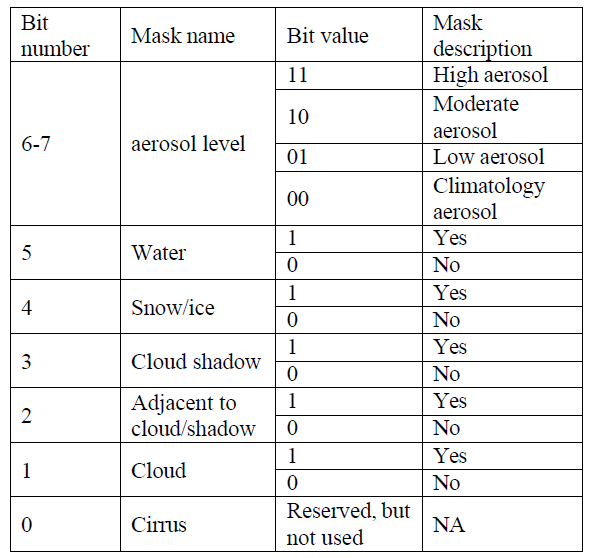

The quality table above can be found in section 6.4 of the [HLS V2.0 User Guide](https://lpdaac.usgs.gov/documents/1326/HLS_User_Guide_V2.pdf). We can also make our own dataframe to reference which bit numbers are associated with what description.

In [ ]:
qa_df = pd.DataFrame(data={'bit_number':(np.arange(0,7)),'mask_name':(['Cirrus','Cloud','Cloud Adjacent','Cloud Shadow','Snow/Ice','Water','Aerosol Level'])})
qa_df

Create a function to unpacked the quality layers and build an `xarray.dataset` from the quality data.

In [ ]:
# Function to create unpacked quality xarray.dataset, fmask_xa: an xarray.dataarray of the HLS fmask layer
def unpack_fmask(fmask_xa, chunk_size):
    # Create Dataframe describing bit numbers
    qa_df = pd.DataFrame(data={'bit_number':(np.arange(0,7)),'mask_name':(['Cirrus','Cloud','Cloud Adjacent','Cloud Shadow','Snow/Ice','Water','Aerosol Level'])})
    # Convert from dask array to numpy array to use unpackbits - we will put it back into a dask array later
    fmask_np = np.array(fmask_xa.data)
    # Unpack the bits using numpy - First creating a new dimension to unpack along and converting to uint8 from float32
    unpacked_qa = np.unpackbits(fmask_np[np.newaxis,:,:].astype('uint8'),axis=0)
    # Since our Aerosols are dependent on 2 bands we can change use values 0 - 3 instead of binary to represent the possible conditions and combine them into a single layer by multiplying the bit 7 by 2.
    unpacked_qa[0,:,:] *=2
    aerosols = unpacked_qa[0,:,:] + unpacked_qa[1,:,:]
    # Add the combined Aerosol layer to the remaining quality layers (excluding 1&2 which were Aerosols) 
    qa_data = np.concatenate((aerosols[np.newaxis,:,:],unpacked_qa[2:,:,:]), axis=0)
    # Flip will reverse the order of layers, so our bit-numbers will align with them
    qa_data = np.flip(qa_data, axis=0)
    # Create an xarray dataset to represent the quality values - first create a dictionary defining the data vars
    data_vars = {'quality_layers':(['band','y','x'], qa_data)}
    # Next do the same for the coordinates. Here we unpack dictionaries from the existing fmask xarray dataset to populate the x and y dimensions.
    coords = {'band':(['band'], qa_df['bit_number']), **fmask_cropped.coords, 'mask_description':(['band'], qa_df['mask_name'])}
    # Create and chunk dataset (back to dask array)
    qa_ds = xr.Dataset(data_vars=data_vars, coords=coords, attrs=fmask_cropped.attrs).chunk(chunk_size)
    return qa_ds

In [ ]:
qa_ds = unpack_fmask(fmask_cropped, chunk_size)
qa_ds.sel(band=6).hvplot.image(aspect='equal')

We can create a list of bit numbers and aerosol values we want to mask out of our analysis. Show our dataframe of bit numbers and descriptions.

In [ ]:
qa_df

For this example, we want to exclude all of the binary layers (0 through 5) and we want to only include pixels with low aerosols. Make a list containing the mask layers you want to filter out of the dataset, and pick an aerosol level threshold to filter using the aerosol layer.

In [ ]:
# Specify Mask Layers to include (0-5 only)
mask_selection = [0,1,2,3,4,5]
# Select Aerosol threshold (inclusive) for what is considered too high (0 = Climate, 1 = Low, 2 = moderate, 3 = high)
aerosol_threshold = 1

Create a function to mask (filter out) the selected quality layers and the aerosol levels that fall above your desired threshold.

In [ ]:
# Create a function to mask mask where where aerosol threshold >= value specified 
def apply_mask(dataset,quality_dataset, mask_sel, aerosol_thresh):
    aerosol_layer = np.where(quality_dataset['quality_layers'].data[6,:,:] > aerosol_thresh, 1, 0) 
    # Concatenate with other selected mask layers
    mask_layers = np.concatenate((quality_dataset['quality_layers'].data[mask_selection,:,:], aerosol_layer[np.newaxis,:,:]), axis=0)
    # Combine them into a single mask
    combined_mask = np.sum(mask_layers, axis=0)
    combined_mask[combined_mask > 1] = 1
    # Apply Mask
    masked_evi = dataset.copy() # Create Copy of our HLS dataset (in this case EVI)
    masked_evi.data[combined_mask == 1] = np.nan # Use numpy indexing to set values in our mask to np.nan
    return(masked_evi)

# Apply the mask to our `xarray.Dataset`

Apply the mask and plot the masked and non-masked EVI side by side.

In [ ]:
# Apply Mask
masked_evi = apply_mask(evi_cropped, qa_ds, mask_selection, aerosol_threshold)
masked_evi.hvplot.image(aspect='equal', cmap='YlGn', frame_width=300).opts(title='Masked EVI') + evi_cropped.hvplot.image(aspect='equal', cmap='YlGn', frame_width=300).opts(title='EVI')

Above we can see the small region in the north west edge of our ROI has been masked out.

### 5.3 Export to COG <a id="2.1"></a>

In this section, create an output filename and export the quality filtered EVI to COG. 

In [ ]:
original_name = evi_band_links[3].split('/')[-1]
original_name

The standard format  for HLS S30 V2.0 and HLS L30 V2.0 filenames is as follows:
> **HLS.S30/HLS.L30**: Product Short Name    
**T10TEK**: MGRS Tile ID (T+5-digits)  
**2020273T190109**: Julian Date and Time of Acquisition (YYYYDDDTHHMMSS)  
**v2.0**: Product Version   
**B8A/B05**: Spectral Band  
**.tif**: Data Format (Cloud Optimized GeoTIFF)  

For additional information on HLS naming conventions, be sure to check out the [HLS Overview Page](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-naming-conventions).

Now modify the filename to describe that its EVI, cropped to an ROI and masked.

In [ ]:
out_name = f"{original_name.split('.B')[0]}_EVI_cropped_masked.tif"  # Generate output name from the original filename
out_name

Use the `COG` driver to write a local raster output. A cloud-optimized geotiff (COG) is a geotiff file that has been tiled and includes overviews so it can be accessed and previewed without having to load the entire image into memory at once.

In [ ]:
out_folder = '../../data/'
#masked_evi.rio.to_raster(raster_path=f'{out_folder}{out_name}', driver='COG')

In [ ]:
del masked_evi, evi_cropped, out_folder, out_name, mask_selection, aerosol_threshold, qa_df, qa_ds, fmask_cropped, red_cropped, blue_cropped, nir_cropped, nir, red, blue, fmask

---

## 6. Automation <a id="automation"></a>

In this section, automate sections 4-5 for each HLS item that intersects our spatiotemporal subset of interest. Loop through each item and subset to the desired bands, load the spatial subset into memory, apply the scale factor, calculate EVI, quality filter, and export as a Cloud Optimized GeoTIFF. 

In [ ]:
len(hls_results_urls)

In [ ]:
# This Cell is for testing purposes only. Item 16 writes different values 
#    I think some sort of scaling or something is being applied during the writing stage, but I'm unsure where its coming from.
mask_selection = [0,1,2,3,4,5]
aerosol_threshold = 1

h = hls_results_urls[16]
outName = h[0].split('/')[-1].replace('.VAA.tif', '_EVI_cropped_masked_test.tif')
    
# Check if file already exists in output directory, if yes--skip that file and move to the next observation
#if os.path.exists(f'../../data/{outName}'):
   # print(f"{outName} has already been processed and is available in this directory, moving to next file.")
    
#try:
evi_band_links = []
if h[0].split('/')[4] == 'HLSS30.020':
    evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE FMASK
else:
    evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE FMASK
    
for a in h: 
    if any(b in a for b in evi_bands):
        evi_band_links.append(a)

# Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
chunk_size = dict(band=1, x=512, y=512)
for e in evi_band_links:
    print(e)
    if e.rsplit('.', 2)[-2] == evi_bands[0]:      # NIR index
        nir = rxr.open_rasterio(e, mask_and_scale=True, chunks=chunk_size).squeeze('band', drop=True)
    elif e.rsplit('.', 2)[-2] == evi_bands[1]:    # red index
        red = rxr.open_rasterio(e, mask_and_scale=True, chunks=chunk_size).squeeze('band', drop=True)
    elif e.rsplit('.', 2)[-2] == evi_bands[2]:    # blue index
        blue = rxr.open_rasterio(e, mask_and_scale=True, chunks=chunk_size).squeeze('band', drop=True)
    elif e.rsplit('.', 2)[-2] == evi_bands[3]:    # Fmask index
        fmask = rxr.open_rasterio(e, chunks=chunk_size).squeeze('band', drop=True)
print("The COGs have been loaded into memory!")

fsUTM = field.to_crs(nir.spatial_ref.crs_wkt)

# Crop to our ROI and apply scaling and masking
nir = nir.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
red = red.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
blue = blue.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
fmask_cropped = fmask.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
nir = fix_scaling(nir)
red = fix_scaling(red)
blue = fix_scaling(blue)
evi = calc_evi(red, blue, nir)

# Quality Filter the data
qa_ds = unpack_fmask(fmask_cropped, chunk_size)
masked_evi = apply_mask(evi, qa_ds, mask_selection, aerosol_threshold)
masked_evi.rio.to_raster(raster_path=f'../../data/{outName}', driver='COG')

In [ ]:
ds = rxr.open_rasterio(f'../../data/{outName}').squeeze('band', drop=True)
masked_evi.hvplot.image(aspect='equal', cmap='YlGn', frame_width=300) + ds.hvplot.image(x='x', y='y', aspect='equal', cmap='YlGn', frame_width=300)

In [ ]:
masked_evi

In [ ]:
ds

Be patient with the for loop below, it may take a few minutes to complete. 

In [ ]:
# Now put it all together and loop through each of the files, visualize, calculate statistics on EVI, and export

# Specify Mask Layers to include (0-5 only)
mask_selection = [0,1,2,3,4,5]

# Select Aerosol threshold (inclusive) for what is considered too high (0 = Climate, 1 = Low, 2 = moderate, 3 = high)
aerosol_threshold = 1

for j, h in enumerate(hls_items):
    outName = h['assets']['browse']['href'].split('/')[-1].replace('.jpg', '_EVI_cropped_masked.tif')
    
    # Check if file already exists in output directory, if yes--skip that file and move to the next observation
    if os.path.exists(f'../../data/{outName}'):
        print(f"{outName} has already been processed and is available in this directory, moving to next file.")
        continue
    
    evi_band_links = []
    if h.split('/')[4] == 'HLSS30.020':
        evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE FMASK
    else:
        evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE FMASK
    
    for a in h: 
        if any(b in a for b in evi_bands):
            evi_band_links.append(a)

    # Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
    chunk_size = dict(band=1, x=512, y=512)
    for e in evi_band_links:
        print(e)
        if e.rsplit('.', 2)[-2] == evi_bands[0]:      # NIR index
            nir = rxr.open_rasterio(e, mask_and_scale=True, chunks=chunk_size).squeeze('band', drop=True)
        elif e.rsplit('.', 2)[-2] == evi_bands[1]:    # red index
            red = rxr.open_rasterio(e, mask_and_scale=True, chunks=chunk_size).squeeze('band', drop=True)
        elif e.rsplit('.', 2)[-2] == evi_bands[2]:    # blue index
            blue = rxr.open_rasterio(e, mask_and_scale=True, chunks=chunk_size).squeeze('band', drop=True)
        elif e.rsplit('.', 2)[-2] == evi_bands[3]:    # Fmask index
            fmask = rxr.open_rasterio(e, chunks=chunk_size).squeeze('band', drop=True)
    print("The COGs have been loaded into memory!")
    
    fsUTM = field.to_crs(nir.spatial_ref.crs_wkt)

    # Crop to our ROI and apply scaling and masking
    nir = nir.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
    red = red.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
    blue = blue.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
    fmask_cropped = fmask.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
    
    print('Cropped')      
    
    # Fix Scaling
    nir = fix_scaling(nir)
    red = fix_scaling(red)
    blue = fix_scaling(blue)

    # Generate EVI
    
    evi = calc_evi(red, blue, nir)
    print('EVI Calculated')
    
    # Quality Filter the data
    qa_ds = unpack_fmask(fmask_cropped, chunk_size)
    masked_evi = apply_mask(evi, qa_ds, mask_selection, aerosol_threshold)

    print('Masking Complete')

    # Remove any observations that are entirely fill value
    if np.nansum(masked_evi.data).compute() == 0.0:
        print(f"File: {h.split('/')[-1].rsplit('.', 1)[0]} ({h['id']}) was entirely fill values and will not be exported.")
        continue
        
    masked_evi.rio.to_raster(raster_path=f'../../data/{outName}', driver='COG')
    
    print(f"Processing file {j+1} of {len(hls_items)}")

Now there should be multiple COGs exported to your working directory, that will be used in Section 7 to stack into a time series. 

---

## 7. Stacking HLS Data <a id="stackhls"></a>

In this section we will open multiple HLS-derived EVI COGs and stack them into an `xarray` data array along the time dimension. First list the files we created in the `/data/` directory.

In [ ]:
evi_dir = '../../data/'
evi_files = [os.path.abspath(os.path.join(evi_dir, o)) for o in os.listdir(evi_dir) if o.endswith('EVI_cropped_masked.tif')]  # List EVI COGs
#evi_files = [os.path.abspath(os.path.join( for o in os.listdir('../../data/') if o.endswith('EVI_masked.tif')]  # List EVI COGs
evi_files

Create a time index as an xarray variable from the filenames.

In [ ]:
def time_index_from_filenames(evi_files):
    '''
    Helper function to create a pandas DatetimeIndex
    '''
    return [datetime.strptime(f.split('.')[-4], '%Y%jT%H%M%S') for f in evi_files]

time = xr.Variable('time', time_index_from_filenames(evi_files))

In [ ]:
chunks=dict(band=1, x=512, y=512)

evi_ts = xr.concat([rxr.open_rasterio(f, mask_and_scale=True, chunks=chunks).squeeze('band', drop=True) for f in evi_files], dim=time)
evi_ts.name = 'EVI'

In [ ]:
evi_ts = evi_ts.sortby(evi_ts.time)
evi_ts

### 7.2 Visualize Stacked Time Series<a id="4.1"></a>

Below, use the [`hvPlot`](https://hvplot.pyviz.org/index.html) and [`holoviews`](https://www.holoviews.org/) packages to create an interactive time series plot of the HLS derived EVI data.

In [ ]:
# set the x, y, and z (groupby) dimensions, add a colormap/bar and other parameters.
title = 'HLS-derived EVI over an agricultural field in northern California'
evi_ts_plot = evi_ts.isel(time=4).hvplot(x='x', y='y', cmap='YlGn', geo=True, tiles = 'EsriImagery', frame_width=400).opts(title=title)
evi_ts_plot

Next, add a basemap layer to provide better context of the areas surrounding our region of interest.

Looking at the time series above, this farm field is likely a field of walnut trees. Notice the higher EVI (greens) during the summer and browning that is likely occurring from dry conditions as the time series progresses later into autumn. 

Since the data is in an xarray we can intuitively slice or reduce the dataset. Let's select a single time slice from the EVI variable.

You can use slicing to plot data only for a specific observation, for example.

In [ ]:
evi_ts.hvplot.box('EVI', by=['time'], rot=90, box_fill_color='lightblue', width=900, height=400)

Now, plot the time series as boxplots showing the distribution of EVI values for our farm field.

Again, the statistics appear to support the conclusion that greener conditions prevailed in the summer of 2020 vs. later in autumn.

### 7.3 Export Statistics<a id="4.1"></a>

Next, calculate statistics for each observation and export to CSV. 

In [ ]:
# xarray allows you to easily calculate a number of statistics
evi_min = evi_ts.min(('y', 'x'))
evi_max = evi_ts.max(('y', 'x'))
evi_mean = evi_ts.mean(('y', 'x'))
evi_sd = evi_ts.std(('y', 'x'))
evi_count = evi_ts.count(('y', 'x'))
evi_median = evi_ts.median(('y', 'x'))

We now have the `mean` and `standard deviation` for each time slice as well as the `maximum` and `minimum` values. Let's do some plotting! We will use the [`hvPlot`](https://hvplot.pyviz.org/index.html) package to create simple but interactive charts/plots. Hover your curser over the visualization to see the data values. 

In [ ]:
evi_mean.hvplot.line()

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Combine line plots for different statistics
stats = (evi_mean.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Mean')+ 
    evi_sd.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Standard Deviation')
    + evi_max.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Max') + 
    evi_min.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Min')).cols(2)
stats

Remember that these graphs are also interactive--hover over the line to see the value for a given date. 

Finally, create a `pandas` dataframe with the statistics, and export to a CSV file. 

In [ ]:
# Create pandas dataframe from dictionary
df = pd.DataFrame({'Min EVI': evi_min, 'Max EVI': evi_max, 
                   'Mean EVI': evi_mean, 'Standard Deviation EVI': evi_sd, 
                   'Median EVI': evi_median, 'Count': evi_count})

In [ ]:
df.index = evi_ts.time.data                       # Set the observation date as the index
df.to_csv('HLS-Derived_EVI_Stats.csv', index=True)  # Export to CSV

Success! You have now not only learned how to get started with HLS V2.0 data, but have also learned how to navigate cloud-native data using STAC, how to access subsets of COGs, and how to write COGs for your own outputs. Using this jupyter notebook as a workflow, you should now be able to switch to your specific region of interest and re-run the notebook. Good Luck!

## Contact Info  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 05-04-2023  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I. 